In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from tqdm import tqdm
sns.set()

In [2]:
def get_vocab(file, lower = False):
    with open(file, 'r') as fopen:
        data = fopen.read()
    if lower:
        data = data.lower()
    data = data.split()
    vocab = list(set(data))
    return data, vocab

def embed_to_onehot(data, vocab):
    onehot = np.zeros((len(data)), dtype = np.int32)
    for i in range(len(data)):
        onehot[i] = vocab.index(data[i])
    return onehot

In [3]:
text, text_vocab = get_vocab('shakespeare.txt', lower = True)

In [4]:
learning_rate = 0.001
batch_size = 16
sequence_length = 32
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(text) - sequence_length - 1)

In [5]:
class Model:
    def __init__(
        self, num_layers, size_layer, dimension, sequence_length, learning_rate
    ):
        def lstm_cell():
            return tf.nn.rnn_cell.LSTMCell(
                size_layer, sequence_length, state_is_tuple = False
            )

        self.rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell() for _ in range(num_layers)], state_is_tuple = False
        )
        self.X = tf.placeholder(tf.int32, (None, None))
        self.Y = tf.placeholder(tf.int32, (None, None))
        embeddings = tf.Variable(
            tf.random_uniform([len(text_vocab), size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(embeddings, self.X)
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            self.rnn_cells,
            encoder_embedded,
            initial_state = self.hidden_layer,
            dtype = tf.float32,
        )
        self.logits = tf.layers.dense(self.outputs, dimension)
        logits_long = tf.reshape(self.logits, [-1, dimension])
        y_batch_long = tf.reshape(self.Y, [-1])
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = logits_long, labels = y_batch_long
            )
        )
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        self.correct_pred = tf.equal(
            tf.argmax(logits_long, 1), tf.cast(y_batch_long, tf.int64)
        )
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
        self.final_outputs = tf.nn.softmax(self.logits)

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(num_layers, size_layer, len(text_vocab), sequence_length, learning_rate)
sess.run(tf.global_variables_initializer())

In [7]:
def train_random_sequence():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    for i in pbar:
        last_time = time.time()
        init_value = np.zeros((batch_size, num_layers * 2 * size_layer))
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length))
        batch_id = random.sample(possible_batch_id, batch_size)
        for n in range(sequence_length):
            id1 = embed_to_onehot([text[k + n] for k in batch_id],text_vocab)
            id2 = embed_to_onehot([text[k + n + 1] for k in batch_id],text_vocab)
            batch_x[:,n] = id1
            batch_y[:,n] = id2
        last_state, _, loss = sess.run([model.last_state, model.optimizer, model.cost], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.hidden_layer: init_value})
        accuracy = sess.run(model.accuracy, feed_dict = {model.X: batch_x, 
                                                         model.Y: batch_y, 
                                                         model.hidden_layer: init_value})
        ACCURACY.append(accuracy); LOST.append(loss)
        init_value = last_state
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [8]:
LOST, ACCURACY = train_random_sequence()

epoch: 100%|██████████| 3000/3000 [11:22<00:00,  4.88it/s, accuracy=0.104, cost=6.09] 


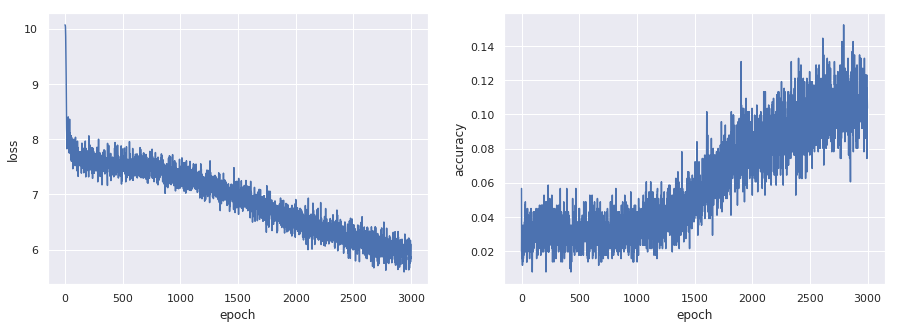

In [9]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [10]:
split_text = text
selected_index = np.random.randint(0, len(split_text) - 5)
tag = split_text[selected_index:selected_index + 5]
print(tag)

['would', 'grow', 'into', 'extremes.', 'sly:']


In [15]:
def generate_based_sequence(length_sentence, argmax = False):
    sentence_generated = tag[:]
    onehot = embed_to_onehot(tag, text_vocab)
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for i in range(len(tag)):
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[i]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    for i in range(length_sentence):
        if argmax:
            char = np.argmax(prob[0][0])
        else:
            char = np.random.choice(range(len(text_vocab)), p = prob[0][0])
        element = [text_vocab[char]]
        sentence_generated += element
        onehot = embed_to_onehot(element, text_vocab)
        batch_x = np.zeros((1, 1))
        batch_x[0] = onehot[0]
        last_state, prob = sess.run(
            [model.last_state, model.final_outputs],
            feed_dict = {model.X: batch_x, model.hidden_layer: init_value},
        )
        init_value = last_state

    return ' '.join(sentence_generated)

In [19]:
print(generate_based_sequence(100,True))

would grow into extremes. sly: i have been a man to the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the king of the


In [18]:
print(generate_based_sequence(100,False))

would grow into extremes. sly: he hath confess in me, tend no is my weakness too: the nature but no that's after a brace of chastity as made or honour to whip the other little meaning. duchess and tribunes, die; the cedar can have so maid you do take my word signior death? what, no, sir, his remember, be a part of england, that that came together to all her, to them, romeo: victory, that worthy sayings we will needs grieve me? or his son, of an steeds, lord cold lord mayor: true, away, on fortune sir, not sell you forth. king edward iv: the
